In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pip install -U ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.1 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
model = YOLO("/content/drive/MyDrive/aug_weights/best.pt")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
import time

start = time.time()
img_path = "/content/drive/MyDrive/dataset/train/train/images/frame_014396.jpg"
model.predict(source=img_path, conf=0.25, save=False)
print("Single inference time:", time.time() - start)



image 1/1 /content/drive/MyDrive/dataset/train/train/images/frame_014396.jpg: 384x640 1 UAP, 2 Persons, 355.6ms
Speed: 17.7ms preprocess, 355.6ms inference, 49.0ms postprocess per image at shape (1, 3, 384, 640)
Single inference time: 15.449150562286377


In [ ]:
import numpy as np

confs = []

for i in range(10):
    r = model.predict(source=img_path, conf=0.25, save=False, verbose=False)[0]
    if r.boxes is not None and len(r.boxes) > 0:
        confs.append(float(r.boxes.conf[0]))

print("Confidences:", confs)
print("Mean:", np.mean(confs))
print("Std:", np.std(confs))


Confidences: [0.9617680311203003, 0.9617680311203003, 0.9617680311203003, 0.9617680311203003, 0.9617680311203003, 0.9617680311203003, 0.9617680311203003, 0.9617680311203003, 0.9617680311203003, 0.9617680311203003]
Mean: 0.9617680311203003
Std: 0.0


In [ ]:
import torch
import torch.nn as nn

def enable_dropout(model):
    """
    Enable dropout layers during inference.
    """
    for m in model.model.modules():
        if isinstance(m, nn.Dropout) or isinstance(m, nn.Dropout2d):
            m.train()

print("Dropout enabled.")


Dropout enabled.


In [ ]:
enable_dropout(model)


In [ ]:
import numpy as np

img_path = "/content/drive/MyDrive/dataset/train/train/images/frame_014396.jpg"

confs = []

for i in range(10):
    r = model.predict(source=img_path, conf=0.25, save=False, verbose=False)[0]
    if r.boxes is not None and len(r.boxes) > 0:
        confs.append(float(r.boxes.conf[0]))

print("Confidences:", confs)
print("Mean:", np.mean(confs))
print("Std:", np.std(confs))


Confidences: [0.9617680311203003, 0.9617680311203003, 0.9617680311203003, 0.9617680311203003, 0.9617680311203003, 0.9617680311203003, 0.9617680311203003, 0.9617680311203003, 0.9617680311203003, 0.9617680311203003]
Mean: 0.9617680311203003
Std: 0.0



🚀 MC DROPOUT UNCERTAINTY QUANTIFICATION TEST

🔧 Injecting dropout via forward hooks...
✅ Registered 12 dropout hooks on backbone blocks

🔍 Validating stochastic behavior...
  Run 1: 3 detections, confs: [0.8919684886932373, 0.5343638062477112, 0.1982494294643402]...
  Run 2: 3 detections, confs: [0.8312910795211792, 0.41157016158103943, 0.3511531949043274]...
  Run 3: 3 detections, confs: [0.8151993155479431, 0.5636024475097656, 0.4817907512187958]...
  Run 4: 1 detections, confs: [0.7559133768081665]...
  Run 5: 3 detections, confs: [0.771364688873291, 0.5851150155067444, 0.42319658398628235]...
✅ Stochastic behavior confirmed - outputs vary between runs!

--------------------------------------------------
Running full MC Dropout analysis...
--------------------------------------------------
▶ Running 30 stochastic forward passes...
  Pass 10/30 complete
  Pass 20/30 complete
  Pass 30/30 complete

📊 UNCERTAINTY ANALYSIS RESULTS

⏱️  Time: 6.87 seconds (0.229s per iteration)

Consens

/tmp/ipython-input-2818494219.py:321: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-2818494219.py:324: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


💾 Saved visualization to /content/mc_dropout_results.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


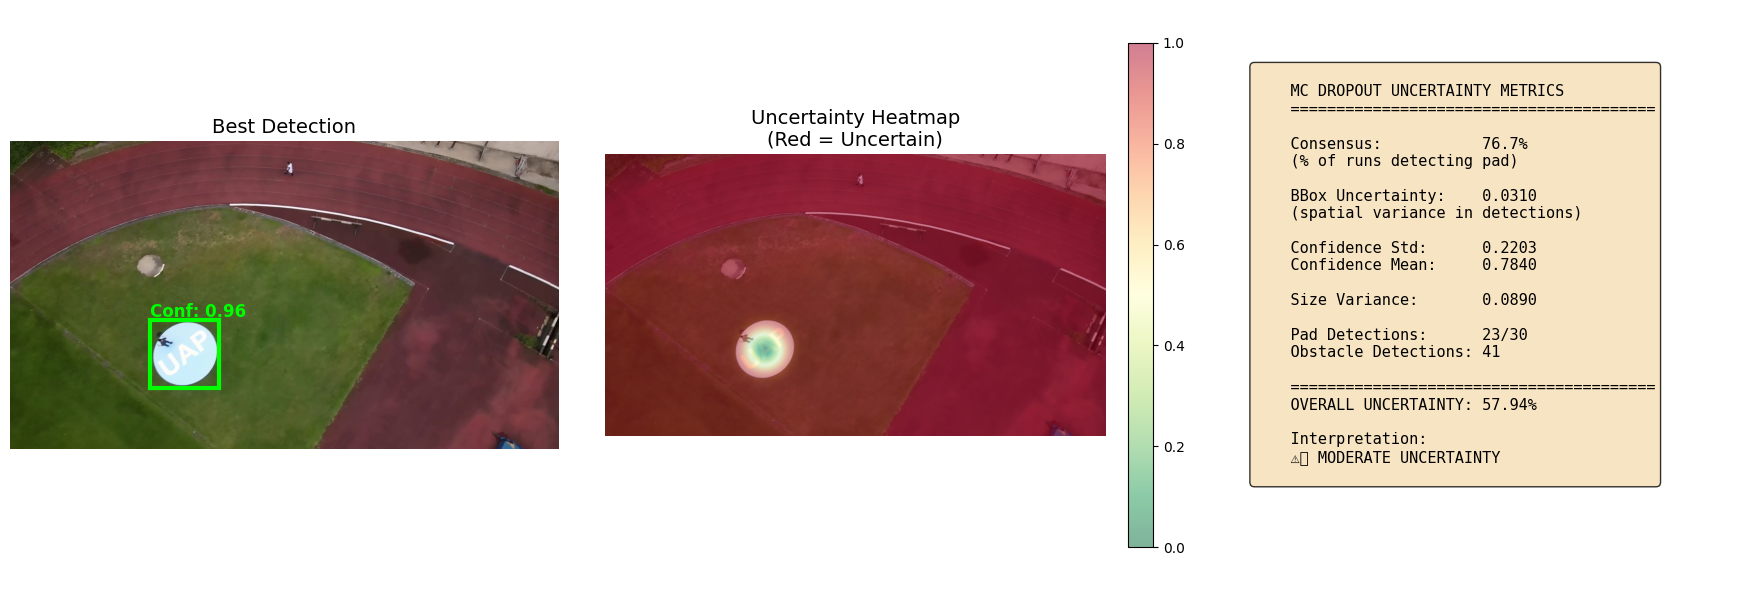

🧹 Cleaned up dropout hooks

✅ MC Dropout Phase 3.1 Complete!


In [ ]:
"""
=====================================
WORKING MC DROPOUT FOR ULTRALYTICS YOLO
=====================================
Uses forward hooks to actually inject dropout into inference
"""

import torch
import torch.nn as nn
import numpy as np
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import time
from typing import Dict, List, Tuple

# =====================================
# CONFIGURATION
# =====================================
MODEL_PATH = "/content/drive/MyDrive/aug_weights/best.pt"
TEST_IMAGE = "/content/drive/MyDrive/dataset/train/train/images/frame_014396.jpg"
N_ITER = 30
DROPOUT_P = 0.2

# =====================================
# MC DROPOUT CLASS
# =====================================

class MCDropoutYOLO:
    """
    Monte Carlo Dropout for YOLO uncertainty estimation.
    Uses forward hooks to inject dropout - this actually works!
    """

    def __init__(self, model_path: str, n_iterations: int = 30, dropout_rate: float = 0.2):
        self.model = YOLO(model_path)
        self.n_iterations = n_iterations
        self.dropout_rate = dropout_rate

        # Track hooks and dropout state
        self.hooks = []
        self.dropout_active = False

        print("🔧 Injecting dropout via forward hooks...")
        self._inject_dropout_hooks()

    def _inject_dropout_hooks(self):
        """
        Use forward hooks to add dropout AFTER specific layers.
        This modifies the output during forward pass.
        """
        hook_count = 0

        for name, module in self.model.model.named_modules():
            class_name = module.__class__.__name__

            # Target backbone feature blocks (not detection heads)
            if class_name in ['C2f', 'C3', 'SPPF', 'Bottleneck']:

                # Create closure to capture dropout layer
                def create_hook():
                    dropout = nn.Dropout2d(p=self.dropout_rate)

                    def hook_fn(module, input, output):
                        # Only apply dropout when active
                        if self.dropout_active:
                            if isinstance(output, torch.Tensor) and output.dim() == 4:
                                dropout.train()  # Ensure dropout is active
                                return dropout(output)
                        return output

                    return hook_fn

                hook = module.register_forward_hook(create_hook())
                self.hooks.append(hook)
                hook_count += 1

        print(f"✅ Registered {hook_count} dropout hooks on backbone blocks")

    def predict_with_uncertainty(self, image_path: str) -> Dict:
        """
        Run MC Dropout inference with multiple stochastic forward passes.
        """
        all_predictions = []

        # Enable stochastic dropout
        self.dropout_active = True

        print(f"▶ Running {self.n_iterations} stochastic forward passes...")

        for i in range(self.n_iterations):
            # Lower conf threshold to catch uncertain detections
            results = self.model.predict(image_path, conf=0.15, verbose=False)
            all_predictions.append(results[0])

            if (i + 1) % 10 == 0:
                print(f"  Pass {i+1}/{self.n_iterations} complete")

        # Disable dropout
        self.dropout_active = False

        # Aggregate results
        return self._aggregate_predictions(all_predictions, image_path)

    def _aggregate_predictions(self, predictions: List, image_path: str) -> Dict:
        """
        Aggregate multiple stochastic predictions into uncertainty metrics.
        """
        img = cv2.imread(image_path)
        h, w = img.shape[:2]

        pad_detections = []
        obstacle_detections = []

        # Collect all detections across iterations
        for pred in predictions:
            if pred.boxes is None or len(pred.boxes) == 0:
                continue

            for box in pred.boxes:
                class_id = int(box.cls[0])
                conf = float(box.conf[0])
                bbox = box.xyxy[0].cpu().numpy()

                detection = {
                    'class_id': class_id,
                    'confidence': conf,
                    'bbox': bbox,
                    'center': [(bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2]
                }

                # Adjust class IDs based on your dataset
                if class_id in [1, 2]:  # UAP or UAI (landing pads)
                    pad_detections.append(detection)
                elif class_id in [0, 3]:  # Vehicle or Person (obstacles)
                    obstacle_detections.append(detection)

        # ========== COMPUTE METRICS ==========

        # 1. Consensus: How often was a pad detected?
        consensus = len(pad_detections) / self.n_iterations

        # 2. Bbox Uncertainty: Spatial variance in detections
        bbox_uncertainty = 0.0
        if len(pad_detections) > 1:
            centers = np.array([d['center'] for d in pad_detections])
            bbox_uncertainty = np.std(centers) / np.sqrt(w**2 + h**2)

        # 3. Confidence Variance: How stable are confidence scores?
        conf_std = 0.0
        conf_mean = 0.0
        if len(pad_detections) > 1:
            confs = [d['confidence'] for d in pad_detections]
            conf_std = np.std(confs)
            conf_mean = np.mean(confs)

        # 4. Best detection
        best_pad = max(pad_detections, key=lambda x: x['confidence']) if pad_detections else None

        # 5. Size variance
        size_std = 0.0
        if len(pad_detections) > 1:
            sizes = [(d['bbox'][2] - d['bbox'][0]) * (d['bbox'][3] - d['bbox'][1])
                     for d in pad_detections]
            size_std = np.std(sizes) / np.mean(sizes) if np.mean(sizes) > 0 else 0

        # 6. Create uncertainty heatmap
        uncertainty_map = self._create_uncertainty_heatmap(pad_detections, (h, w))

        # 7. Compute overall uncertainty score (0-1, higher = more uncertain)
        overall_uncertainty = self._compute_overall_uncertainty(
            consensus, bbox_uncertainty, conf_std
        )

        return {
            'best_pad_detection': best_pad,
            'consensus': consensus,
            'bbox_uncertainty': bbox_uncertainty,
            'conf_std': conf_std,
            'conf_mean': conf_mean,
            'size_std': size_std,
            'num_pad_detections': len(pad_detections),
            'num_obstacle_detections': len(obstacle_detections),
            'obstacles': obstacle_detections[:5],  # Top 5 obstacles
            'uncertainty_map': uncertainty_map,
            'overall_uncertainty': overall_uncertainty,
            'total_iterations': self.n_iterations
        }

    def _compute_overall_uncertainty(self, consensus: float,
                                      bbox_unc: float, conf_std: float) -> float:
        """
        Combine metrics into single uncertainty score.
        0 = certain, 1 = uncertain
        """
        # Weights for each component
        w_consensus = 0.4
        w_bbox = 0.3
        w_conf = 0.3

        # Convert consensus to uncertainty (high consensus = low uncertainty)
        consensus_unc = 1.0 - consensus

        # Normalize bbox uncertainty (assuming 0.05 is high)
        bbox_unc_norm = min(bbox_unc / 0.05, 1.0)

        # Normalize conf std (assuming 0.2 is high)
        conf_unc_norm = min(conf_std / 0.2, 1.0)

        overall = (w_consensus * consensus_unc +
                   w_bbox * bbox_unc_norm +
                   w_conf * conf_unc_norm)

        return min(max(overall, 0.0), 1.0)

    def _create_uncertainty_heatmap(self, detections: List[Dict],
                                     img_size: Tuple[int, int]) -> np.ndarray:
        """
        Create spatial uncertainty heatmap.
        Low values = high detection density = low uncertainty
        """
        h, w = img_size
        heatmap = np.zeros((h, w), dtype=np.float32)

        if not detections:
            return np.ones((h, w), dtype=np.float32)  # Max uncertainty

        # Add gaussian for each detection center
        for det in detections:
            cx, cy = int(det['center'][0]), int(det['center'][1])

            # Gaussian kernel
            sigma = 50
            y, x = np.ogrid[:h, :w]
            gaussian = np.exp(-((x - cx)**2 + (y - cy)**2) / (2 * sigma**2))
            heatmap += gaussian

        # Normalize and invert (high density = low uncertainty)
        if heatmap.max() > 0:
            heatmap = 1.0 - (heatmap / heatmap.max())

        return heatmap

    def cleanup(self):
        """Remove hooks when done."""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        print("🧹 Cleaned up dropout hooks")


# =====================================
# VISUALIZATION FUNCTIONS
# =====================================

def visualize_results(image_path: str, results: Dict, save_path: str = None):
    """Create comprehensive visualization of uncertainty analysis."""

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Original image with best detection
    axes[0].imshow(img)
    axes[0].set_title('Best Detection', fontsize=14)

    if results['best_pad_detection']:
        bbox = results['best_pad_detection']['bbox']
        conf = results['best_pad_detection']['confidence']

        rect = plt.Rectangle(
            (bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
            fill=False, color='lime', linewidth=3
        )
        axes[0].add_patch(rect)
        axes[0].text(bbox[0], bbox[1] - 10, f'Conf: {conf:.2f}',
                     color='lime', fontsize=12, fontweight='bold')

    axes[0].axis('off')

    # 2. Uncertainty heatmap
    axes[1].imshow(img)
    heatmap = axes[1].imshow(results['uncertainty_map'],
                              cmap='RdYlGn_r', alpha=0.5)
    axes[1].set_title('Uncertainty Heatmap\n(Red = Uncertain)', fontsize=14)
    axes[1].axis('off')
    plt.colorbar(heatmap, ax=axes[1], fraction=0.046, pad=0.04)

    # 3. Metrics summary
    axes[2].axis('off')
    metrics_text = f"""
    MC DROPOUT UNCERTAINTY METRICS
    {'='*40}

    Consensus:           {results['consensus']:.1%}
    (% of runs detecting pad)

    BBox Uncertainty:    {results['bbox_uncertainty']:.4f}
    (spatial variance in detections)

    Confidence Std:      {results['conf_std']:.4f}
    Confidence Mean:     {results['conf_mean']:.4f}

    Size Variance:       {results['size_std']:.4f}

    Pad Detections:      {results['num_pad_detections']}/{results['total_iterations']}
    Obstacle Detections: {results['num_obstacle_detections']}

    {'='*40}
    OVERALL UNCERTAINTY: {results['overall_uncertainty']:.2%}

    Interpretation:
    {'✅ HIGH CONFIDENCE' if results['overall_uncertainty'] < 0.3 else '⚠️ MODERATE UNCERTAINTY' if results['overall_uncertainty'] < 0.6 else '❌ HIGH UNCERTAINTY'}
    """

    axes[2].text(0.1, 0.9, metrics_text, transform=axes[2].transAxes,
                 fontsize=11, verticalalignment='top', fontfamily='monospace',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"💾 Saved visualization to {save_path}")

    plt.show()


def validate_stochasticity(mc_model, image_path: str) -> bool:
    """
    Verify that MC Dropout is actually producing different outputs.
    """
    print("\n🔍 Validating stochastic behavior...")

    mc_model.dropout_active = True

    results = []
    for i in range(5):
        pred = mc_model.model.predict(image_path, conf=0.15, verbose=False)[0]
        n_detections = len(pred.boxes) if pred.boxes is not None else 0

        # Get confidence scores
        confs = []
        if pred.boxes is not None and len(pred.boxes) > 0:
            confs = [float(b.conf[0]) for b in pred.boxes]

        results.append({'n': n_detections, 'confs': confs})
        print(f"  Run {i+1}: {n_detections} detections, confs: {confs[:3]}...")

    mc_model.dropout_active = False

    # Check for variation
    n_detections = [r['n'] for r in results]
    has_variation = len(set(n_detections)) > 1 or any(
        len(set(tuple(r['confs']) for r in results if r['confs'])) > 1
        for r in results
    )

    if has_variation:
        print("✅ Stochastic behavior confirmed - outputs vary between runs!")
        return True
    else:
        print("⚠️ Outputs are identical - dropout may not be working properly")
        return False


# =====================================
# MAIN TEST
# =====================================

print("\n" + "="*50)
print("🚀 MC DROPOUT UNCERTAINTY QUANTIFICATION TEST")
print("="*50 + "\n")

# Initialize
mc_yolo = MCDropoutYOLO(
    model_path=MODEL_PATH,
    n_iterations=N_ITER,
    dropout_rate=DROPOUT_P
)

# Validate stochasticity first
is_stochastic = validate_stochasticity(mc_yolo, TEST_IMAGE)

if not is_stochastic:
    print("\n⚠️ Warning: MC Dropout may not be working. Consider increasing dropout_rate or checking layer targets.")

# Run full uncertainty analysis
print("\n" + "-"*50)
print("Running full MC Dropout analysis...")
print("-"*50)

start_time = time.time()
results = mc_yolo.predict_with_uncertainty(TEST_IMAGE)
elapsed = time.time() - start_time

# Print results
print("\n" + "="*50)
print("📊 UNCERTAINTY ANALYSIS RESULTS")
print("="*50)

print(f"\n⏱️  Time: {elapsed:.2f} seconds ({elapsed/N_ITER:.3f}s per iteration)")

print(f"""
Consensus:            {results['consensus']:.1%}
BBox Uncertainty:     {results['bbox_uncertainty']:.5f}
Confidence Std:       {results['conf_std']:.4f}
Confidence Mean:      {results['conf_mean']:.4f}
Size Variance:        {results['size_std']:.4f}

Pad Detections:       {results['num_pad_detections']} / {results['total_iterations']}
Obstacle Detections:  {results['num_obstacle_detections']}

Overall Uncertainty:  {results['overall_uncertainty']:.1%}
""")

if results['best_pad_detection']:
    print(f"Best Pad:")
    print(f"  - Class: {results['best_pad_detection']['class_id']}")
    print(f"  - Confidence: {results['best_pad_detection']['confidence']:.4f}")
    print(f"  - BBox: {results['best_pad_detection']['bbox']}")
else:
    print("⚠️ No landing pad detected!")

# Visualize
print("\n📈 Generating visualization...")
visualize_results(TEST_IMAGE, results, save_path='/content/mc_dropout_results.png')

# Cleanup
mc_yolo.cleanup()

print("\n✅ MC Dropout Phase 3.1 Complete!")